In [1]:
# Instalamos open cv en caso no se cuente con el
!pip install opencv-python

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
# Se importan las librerías que utilizaremos
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import numpy as np

## Buscando la mejor forma de aplicar la transformación

In [4]:
# Se importa la información de los caminantes
df = pd.read_csv('../Data/caminantes.csv',sep=';')
df.head()

,Number,Frame,headValid,bodyValid,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
0,0,2,1,1,"295,626","811,142","334,374","851,827","260,713","811,142","396,615","1121,977"
1,1,2,1,1,"901,68","402,431","927,32","430,35","877,443","402,431","957,062","624,178"
2,2,2,1,1,"1646,674","935,667","1691,326","982,208","1596,772","935,667","1729,112","1293,447"
3,3,2,1,1,"882,242","49,998","896,758","65,783","866,204","49,998","916,275","179,462"
4,4,2,1,1,"740,066","229,356","759,934","250,987","719,841","229,356","786,812","405,142"


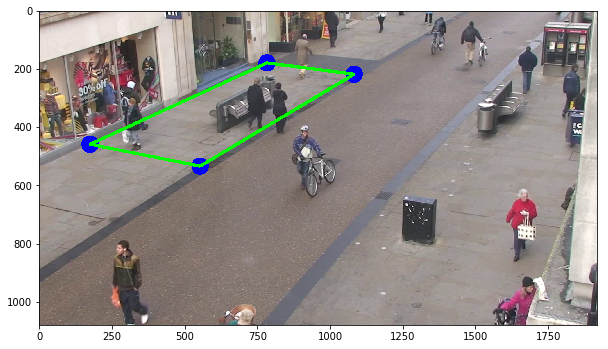

In [5]:
# Se importa el video 
video = cv2.VideoCapture('../Data/calle.avi')
# Se obtiene el primer frame
s,image = video.read() 
# Se almacena la imagen para poder obtener los puntos de transformacion
# cv2.imwrite('../Data/image.png',image) 
# Estos puntos de referencia fueron obtenidos con la ayuda de la herramienta sobre la acera que tiene remarcada las lozas:
# https://yangcha.github.io/iview/iview.html
puntos = np.float32([[175, 458],[784,178],[1084, 217], [554,533]])
# Se copia la imagen y se remarcan los puntos
imgDibujo = image.copy()
for i in range(0, 4):
  cv2.circle(imgDibujo, tuple(puntos[i]), 30, (255,0,0), -1)
# Se usa los puntos para obtener el poligono
pts = puntos.reshape((-1,1,2))
cv2.polylines(imgDibujo, [pts.astype(np.int32)], True, (0,255,0), thickness=10)
b,g,r = cv2.split(imgDibujo)
# Se muestra los puntos de referencia tomados en el frame
imgDibujo = cv2.merge((r,g,b))
plt.figure(figsize=(10,10))
plt.imshow(imgDibujo)
plt.show()

In [22]:
#6 lozas de ancho - Aproximamos ancho de 40 cm
#15 Lozas de alto - Aproximamos largo de 40 cm
pix_unit = 1.7 #pixeles por centimetro
width_street = 240*pix_unit
height_street = 600*pix_unit
#Dimensiones de la imagen final y espacios en pixeles con respecto a la calle:
#--2500--240--2260 (Horizontal)
#--1450--600--1450 (Vertical)
width_img = 5000
height_img = 3500
#Obtenemos los puntos de referencia del frame mostrado anteriormente:
puntos = np.float32([[175, 458],[784,178],[1084, 217], [554,533]])
#Los puntos objetivo en la imagen han sido calculadas anteriormente:
finales=np.float32([(width_img/2,height_img/2+height_street), (width_img/2,height_img/2), (width_img/2+width_street ,height_img/2), (width_img/2+width_street,height_img/2+height_street)])
T_Matrix = cv2.getPerspectiveTransform(puntos, finales)
print('Matrix de transformacion:')
print(T_Matrix)

Matrix de transformacion:
[[ 1.43809441e+00  7.58290450e+00  7.93117275e+02]
 [-6.80696958e-01  8.22103159e+00  1.35956100e+03]
 [-7.73887614e-06  1.76518761e-03  1.00000000e+00]]


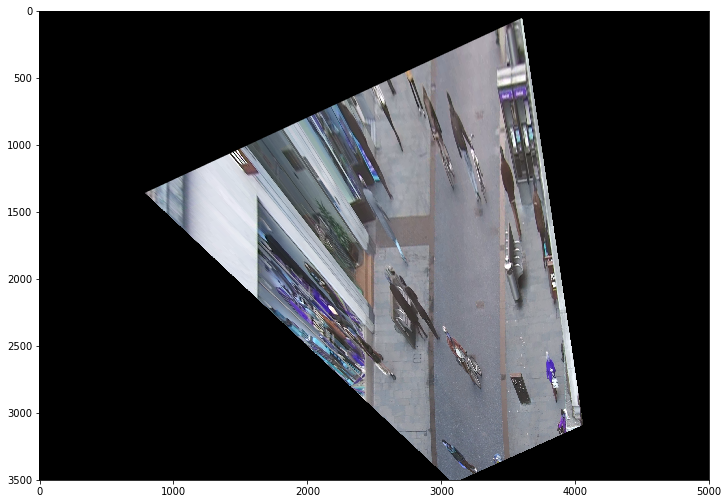

In [23]:
#Dimensiones de la imagen final
final_size=(width_img,height_img)
#Aplicacion de la transformación
imagen_transformada = cv2.warpPerspective(image, T_Matrix, final_size)
#Se grafica la transformación
plt.figure(figsize=(12, 12))
plt.imshow(imagen_transformada)
plt.show()

## Recortando la imagen

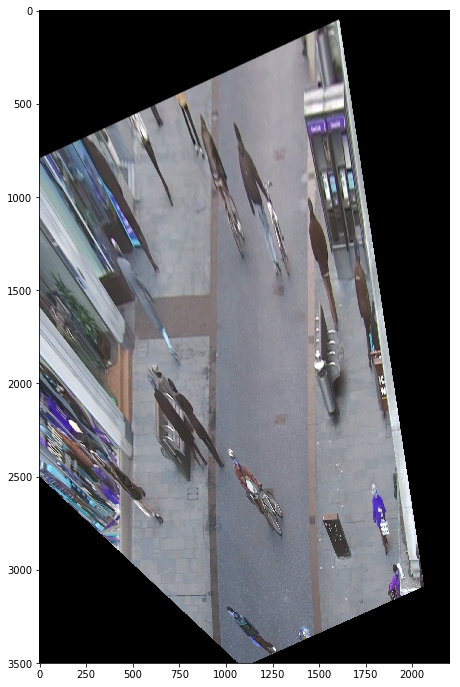

In [25]:
imagen_recortada= imagen_transformada[0:3500,2000:4200]
#Se grafica la imagen recortada
plt.figure(figsize=(12, 12))
plt.imshow(imagen_recortada)
plt.show()

## Funcion para aplicar las transformaciones

In [27]:
def TransformImage(image,T_Matrix,final_size):
    #Aplicacion de la transformación
    imagen_transformada = cv2.warpPerspective(image, T_Matrix, final_size)
    imagen_recortada= imagen_transformada[0:3500,2000:4200]
    return imagen_recortada

## Visualización de video con detección de personas

In [28]:
# Funcion para mostrar 20 primeros frames de video junto con las ventanas para la deteccion de personas y caras
def FrameCapture(path): 
    vidObj = cv2.VideoCapture(path) 
    count = 0
    success = 1
    while success and count<20: 
        success, image = vidObj.read() 
        filter_df = df[df['Frame']==(count)]
        for index,row in filter_df.iterrows():
            start_point = (int(float(row['headLeft'].replace(',','.'))), int(float(row['headTop'].replace(',','.'))) )
            end_point = (int(float(row['headRight'].replace(',','.'))), int(float(row['headBottom'].replace(',','.')))) 
            color = (255, 0, 0) 
            thickness = 2
            image = cv2.rectangle(image, start_point, end_point, color, thickness) 
            start_point2 = (int(float(row['bodyLeft'].replace(',','.'))), int(float(row['bodyTop'].replace(',','.'))) )
            end_point2 = (int(float(row['bodyRight'].replace(',','.'))), int(float(row['bodyBottom'].replace(',','.')))) 
            color2 = (0, 255, 0) 
            image = cv2.rectangle(image, start_point2, end_point2, color2, thickness)
        b,g,r = cv2.split(image)
        frame_rgb = cv2.merge((r,g,b))
        plt.figure(figsize = (20,8))
        plt.subplot(121)
        plt.title('Original') 
        plt.imshow(frame_rgb)
        frame_halcon = TransformImage(frame_rgb,T_Matrix,final_size)
        plt.subplot(122)
        plt.imshow(frame_halcon)
        plt.title('Ojo de halcon') 
        plt.show()
        clear_output(wait=True)
        count += 1

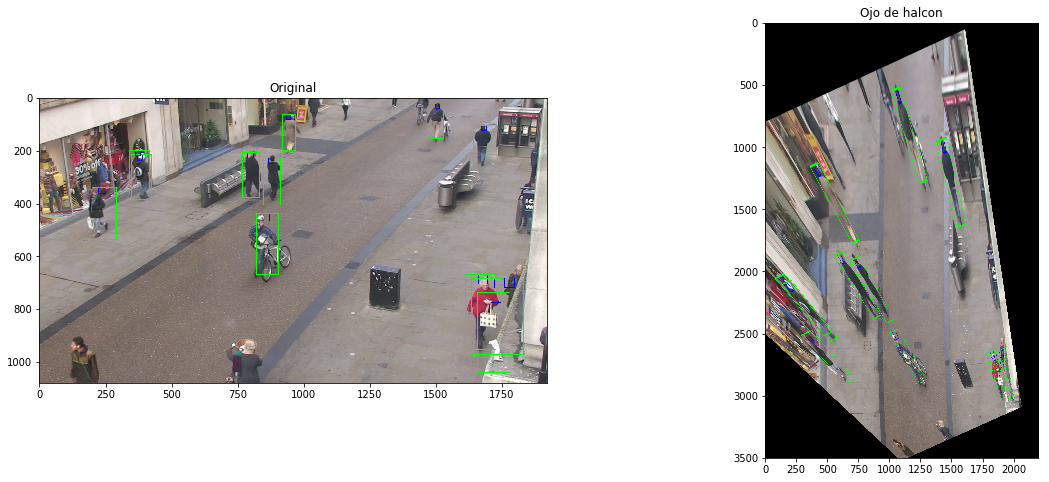

In [29]:
# Se aplica la funcion para visualizar 20 frames del video
FrameCapture('../Data/calle.avi')

### Conclusión:
- Se obtiene una vista de halcon aproximadas
- Se ha aproximado las distancias 